In [1]:
# Around 10% of the tokens don't occur in the vocab generated by BPE.
# They were used to construct the vocab, but only their downstream tokens are used, not these intermediate tokens.
# e.g. machin => machine; "machin" is unused during construction, but only "machine" appears in texts.
# Around 10%@50k, 10%@25k

In [2]:
import json
from tokenizer import SpaceTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [3]:
with open('tokenizers/tokenizer-space.json', 'r', encoding='utf-8') as f: tokenizer_config = json.load(f)

vocab_size = 25000 + 257
vocab_size_pre_removal = int(25000 * 1.05 + 257)
tokenizer = SpaceTokenizer(tokenizer_config["model"]["vocab"], vocab_size_pre_removal)

In [4]:
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train+test+validation") # split="train+test+validation"

def batch_iterator(batch_size=1000):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["text"]

In [5]:
ids = []
for batch in tqdm(batch_iterator()):
    token_ids, token_values = tokenizer.encode(" ".join(batch), return_token_tuple=True)
    ids.extend(token_ids)
print(len(ids))

1810it [04:42,  6.42it/s]

113630884


In [6]:
df_ids = pd.DataFrame(ids, columns=["id"])
df_ids['id'] = df_ids['id'] // 4
df_ids = df_ids['id'].value_counts().rename_axis('id').reset_index(name='counts')
print(df_ids)

          id   counts
0        259  6472588
1         12  4993207
2         14  3930569
3        273  2757867
4        272  2521321
...      ...      ...
26161   5369        1
26162  17070        1
26163  21920        1
26164   5027        1
26165   3346        1

[26166 rows x 2 columns]


In [7]:
df_ids.to_csv("data/wikitext-token-count-space-50k.csv", index=False)

In [8]:
df_counts = pd.read_csv("data/wikitext-token-count-space-50k.csv", index_col="id")
df_counts

,counts
id,
259,6472588
12,4993207
14,3930569
273,2757867
272,2521321
...,...
5369,1
17070,1
21920,1


In [9]:
df_vocab = pd.DataFrame.from_dict(tokenizer_config["model"]["vocab"], orient='index')
df_vocab = df_vocab[0:vocab_size_pre_removal]
df_vocab = df_vocab.reset_index()
df_vocab.columns=['token', 'id']
df_vocab = df_vocab.set_index("id")
df_vocab

,token
id,
0,<|endoftext|>
1,!
2,""""
3,#
4,$
...,...
26502,lL
26503,mings
26504,mÃ¡r


In [10]:
merged_df = pd.merge(df_vocab, df_counts, on='id', how='left')
merged_df['counts'] = merged_df['counts'].fillna(0)
merged_df['counts'] = merged_df['counts'].astype(int)
merged_df

,token,counts
id,,
0,<|endoftext|>,0
1,!,17919
2,"""",1343602
3,#,4824
4,$,46944
...,...,...
26502,lL,966
26503,mings,416
26504,mÃ¡r,312


In [11]:
df_special = merged_df[0:257]
df_tokens = merged_df[257:]
df_tokens

,token,counts
id,,
257,th,98571
258,in,1932224
259,the,6472588
260,an,359533
261,er,70757
...,...,...
26502,lL,966
26503,mings,416
26504,mÃ¡r,312


In [12]:
df_tokens_sorted = df_tokens.sort_values(by='counts', ascending=False)
df_tokens_sorted

,token,counts
id,,
259,the,6472588
273,of,2757867
272,and,2521321
275,to,2013138
258,in,1932224
...,...,...
25639,iroth,0
13013,bL,0
9687,congression,0


In [13]:
df_sorted_vocab = pd.concat([df_special, df_tokens_sorted])
df_sorted_vocab

,token,counts
id,,
0,<|endoftext|>,0
1,!,17919
2,"""",1343602
3,#,4824
4,$,46944
...,...,...
25639,iroth,0
13013,bL,0
9687,congression,0


In [14]:
df_export_vocab = df_sorted_vocab.reset_index().set_index("token")
df_export_vocab = df_export_vocab[0:vocab_size]
df_export_vocab["id"].to_json("tokenizers/space-vocab-sorted.json", orient='index', indent=4, force_ascii=False)

In [19]:
df_removed = df_sorted_vocab[vocab_size:]
df_removed["token"].to_csv("data/scaffold-removed.txt", index=False)

#### Plot token occurrence

In [15]:
df = df_sorted_vocab

min_count = 40
small_count = len(df[df["counts"] <= min_count])
print(small_count / len(df), len(df) - small_count, len(df))

0.04828913117289772 25227 26507


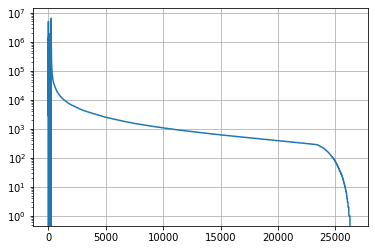

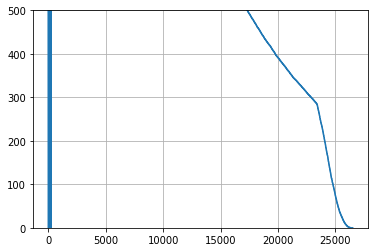

In [20]:
plt.plot(range(len(df)), df["counts"])
plt.yscale("log")
plt.grid()
plt.show()

plt.plot(range(len(df)), df["counts"])
plt.grid()
plt.ylim(0, 500)
plt.show()